In [1]:
from unityagents import UnityEnvironment
from time import perf_counter
import pandas as pd
import copy
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np

from helpers import save_model, plot_losses, plot_scores

In [2]:
env = UnityEnvironment(file_name='Reacher_20.app')
# get the default brain
brain_name = env.brain_names[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
torch.manual_seed(0)


class ActorCritic(nn.Module):
    def __init__(self, params):
        super(ActorCritic, self).__init__()
        self.shared_linear0 = nn.Linear(params['input_dim'], params['shared_hidden0'])
        self.shared_linear1 = nn.Linear(params['shared_hidden0'], params['shared_hidden1'])
        self.shared_linear2 = nn.Linear(params['shared_hidden1'], params['shared_hidden2'])

        self.actor_linear0 = nn.Linear(params['shared_hidden2'], params['actor_hidden'])
        self.actor_linear1 = nn.Linear(params['actor_hidden'], params['actor_hidden'])
        self.actor_linear2 = nn.Linear(params['actor_hidden'], params['output_dim_actor'])

        self.critic_linear0 = nn.Linear(params['shared_hidden2'], params['critic_hidden'])
        self.critic_linear1 = nn.Linear(params['critic_hidden'], params['critic_hidden'])
        self.critic_linear2 = nn.Linear(params['critic_hidden'], params['output_dim_critic'])

    def forward(self, x):
        y = torch.tanh(self.shared_linear0(x))
        y = torch.tanh(self.shared_linear1(y))
        y = torch.tanh(self.shared_linear2(y))

        a = torch.tanh(self.actor_linear0(y))
        a = torch.tanh(self.actor_linear1(a))
        actor = self.actor_linear2(a)
        actor_mean = torch.tanh(actor)

        c = torch.relu(self.critic_linear0(y.detach()))
        c = torch.relu(self.critic_linear1(c))
        critic = torch.relu(self.critic_linear2(c))
        return actor_mean, critic


In [4]:
# hyperparameters
epochs = 28000
lr = 0.00009
gamma = 0.99
clc = 0.1
start_epsilon = 0.3
end_epsilon = 0.1
start_reward_leadup = 50
end_reward_leadup = 1
batch_size = 40

input_dim = 33
shared_hidden0 = 64
shared_hidden1 = 128
shared_hidden2 = 64
actor_hidden = 32
critic_hidden = 32
output_dim_actor = 4
output_dim_critic = 1

losses = []
actor_losses = []
critic_losses = []
scores = []
ave_scores = []

params = {
    'env': env,
    'brain_name': brain_name,
    'start_epsilon': start_epsilon,
    'end_epsilon': end_epsilon,
    'epochs': epochs,
    'lr': lr,
    'gamma': gamma,
    'clc': clc,
    'start_reward_leadup': start_reward_leadup,
    'end_reward_leadup': end_reward_leadup,
    'batch_size': batch_size,
    'losses': losses,
    'scores': scores,
    'ave_scores': ave_scores,
    'actor_losses': actor_losses,
    'critic_losses': critic_losses
}

model_params = {
    'input_dim': input_dim,
    'shared_hidden0': shared_hidden0,
    'shared_hidden1': shared_hidden1,
    'shared_hidden2': shared_hidden2,
    'critic_hidden': critic_hidden,
    'actor_hidden': actor_hidden,
    'output_dim_actor': output_dim_actor,
    'output_dim_critic': output_dim_critic
}

model = ActorCritic(model_params)
optimizer = torch.optim.Adam(lr=params['lr'], params=model.parameters())

In [5]:
def worker(model, optimizer, params, train=True, early_stop_threshold=5., early_stop_target=30.):

    replay = []

    highest_score = 0
    early_stop_captures = []

    for epoch in range(params['epochs']):
        if train and len(early_stop_captures) >= early_stop_threshold:
            print("stopped early because net has reached target score")
            print(early_stop_captures)
            break

        final_score, epsilon, reward_leadup = run_episode(model, replay, params, epoch, train)
        params['scores'].append(final_score)
        stacked_scores = np.stack(params['scores'], axis=1)
        sliced_scores = [agent_scores[-100:] for agent_scores in stacked_scores]
        average_score = np.mean(sliced_scores, axis=1)
        params['ave_scores'].append(average_score)

        if train and len(replay) >= params['batch_size']:
            loss, actor_loss, critic_loss = update_params(replay, optimizer, params)

            params['losses'].append(loss.item())
            params['actor_losses'].append(actor_loss.item())
            params['critic_losses'].append(critic_loss.item())

            ave_scores = np.array2string(average_score, separator=', ', formatter={'float_kind':'{:.3f}'.format}, max_line_width=70).strip('[]')

            if (1 + epoch) % 100 == 0:
                print("Epoch: {}, Epsilon: {:.3f}, Reward Leadup: {:.1f}, Max: {:.4f}\nAve Scores:\n {}\n".format(epoch + 1, epsilon, reward_leadup, np.amax(params['scores']), ave_scores))
        
            replay = []
            early_stop_compare_array = np.full((len(average_score),), early_stop_target, dtype=float)
            if np.all(np.greater(average_score, early_stop_compare_array)):
                early_stop_captures.append(average_score)

In [6]:
def run_episode(model, replay, params, epoch, train):

    env_info = params['env'].reset(train_mode=train)[params['brain_name']]
    state_ = env_info.vector_observations
    num_agents = len(env_info.agents)
    states = torch.from_numpy(state_).float()
    scores = np.zeros(num_agents)               # initialize the score

    values, logprobs, rewards, mean_entropy = [], [], [], torch.tensor(0.)
    done = False

    epsilon = np.clip((params['end_epsilon'] - params['start_epsilon']) / (params['epochs'] - 0) * epoch + params['start_epsilon'], params['end_epsilon'], params['start_epsilon'])
    step_count = 0
    while (done == False):
        step_count += 1
        actor_mean, value = model(states)
        actor_std = torch.tensor(epsilon)

        actor_mean = actor_mean.t()

        action_dist0 = torch.distributions.Normal(actor_mean[0], actor_std)
        action_dist1 = torch.distributions.Normal(actor_mean[1], actor_std)
        action_dist2 = torch.distributions.Normal(actor_mean[2], actor_std)
        action_dist3 = torch.distributions.Normal(actor_mean[3], actor_std)

        mean_entropy = action_dist0.entropy().mean()

        action0 = torch.clamp(action_dist0.sample(), min=-1, max=1)
        action1 = torch.clamp(action_dist1.sample(), min=-1, max=1)
        action2 = torch.clamp(action_dist2.sample(), min=-1, max=1)
        action3 = torch.clamp(action_dist3.sample(), min=-1, max=1)
        logprob0 = action_dist0.log_prob(action0)
        logprob1 = action_dist1.log_prob(action1)
        logprob2 = action_dist2.log_prob(action2)
        logprob3 = action_dist3.log_prob(action3)

        values.append(value.view(-1))
        logprobs.append([logprob0.view(-1), logprob1.view(-1), logprob2.view(-1), logprob3.view(-1)])

        action_list = [action0.detach().numpy().squeeze(), action1.detach().numpy().squeeze(), action2.detach().numpy().squeeze(), action3.detach().numpy().squeeze()]
        action_list = np.stack(action_list, axis=1)
        # send all actions to the environment
        env_info = params['env'].step(action_list)[params['brain_name']]
        # get next state (for each agent)
        state_ = env_info.vector_observations
        # get reward (for each agent)
        reward = env_info.rewards
        # see if episode finished
        done = env_info.local_done[0]

        states = torch.from_numpy(state_).float()
        rewards.append(reward)
        scores += np.array(reward)


    # Update replay buffer for each agent


    stacked_logprob0 = torch.stack([a[0] for a in logprobs], dim=1)
    stacked_logprob1 = torch.stack([a[1] for a in logprobs], dim=1)
    stacked_logprob2 = torch.stack([a[2] for a in logprobs], dim=1)
    stacked_logprob3 = torch.stack([a[3] for a in logprobs], dim=1)

    stacked_values = torch.stack(values, dim=1)
    stacked_rewards = np.stack(rewards, axis=1)

    for agent_index in range(len(env_info.agents)):
  
        agent_values = stacked_values[agent_index]
        agent_logprobs = [stacked_logprob0[agent_index], stacked_logprob1[agent_index], stacked_logprob2[agent_index], stacked_logprob3[agent_index]]
        agent_rewards = stacked_rewards[agent_index]

        actor_losses, critic_losses, losses, reward_leadup = get_trjectory_loss(agent_values, agent_logprobs, agent_rewards, mean_entropy, epoch, params)
        replay.append((scores[agent_index], actor_losses, critic_losses, losses))

    return scores, epsilon, reward_leadup

In [7]:
def get_trjectory_loss(values, logprobs, rewards, mean_entropy, epoch, params):

    reward_leadup = np.clip((params['end_reward_leadup'] - params['start_reward_leadup']) / (params['epochs'] - 0) * epoch + params['start_reward_leadup'], params['end_reward_leadup'], params['start_reward_leadup'])

    [logprob0, logprob1, logprob2, logprob3] = logprobs

    values = values.flip(dims=(0,))
    rewards = torch.Tensor(rewards).flip(dims=(0,))
    logprob0 = logprob0.flip(dims=(0,))
    logprob1 = logprob1.flip(dims=(0,))
    logprob2 = logprob2.flip(dims=(0,))
    logprob3 = logprob3.flip(dims=(0,))

    Returns = []
    total_return = torch.Tensor([0])
    leadup = 0

    for reward_index in range(len(rewards)):
        if rewards[reward_index].item() > 0:
            leadup = reward_leadup
        if leadup == 0:
            total_return = torch.Tensor([0])
        
        total_return = rewards[reward_index] + total_return * params['gamma']
        Returns.append(total_return)
        leadup = leadup - 1 if leadup > 0 else 0

    Returns = torch.stack(Returns).view(-1)
    Returns = F.normalize(Returns, dim=0)

    actor_loss0 = -logprob0 * (Returns - values.detach())
    actor_loss1 = -logprob1 * (Returns - values.detach())
    actor_loss2 = -logprob2 * (Returns - values.detach())
    actor_loss3 = -logprob3 * (Returns - values.detach())

    critic_loss = torch.pow(values - Returns, 2)

    actor_loss0 = actor_loss0.sum()
    actor_loss1 = actor_loss1.sum()
    actor_loss2 = actor_loss2.sum()
    actor_loss3 = actor_loss3.sum()

    critic_loss = critic_loss.sum()

    loss0 = actor_loss0 + params['clc']*critic_loss + 0.01 * mean_entropy
    loss1 = actor_loss1 + params['clc']*critic_loss + 0.01 * mean_entropy
    loss2 = actor_loss2 + params['clc']*critic_loss + 0.01 * mean_entropy
    loss3 = actor_loss3 + params['clc']*critic_loss + 0.01 * mean_entropy

    actor_losses = (actor_loss0, actor_loss1, actor_loss2, actor_loss3)
    losses = (loss0, loss1, loss2, loss3)

    return actor_losses, critic_loss, losses, reward_leadup

In [8]:
def update_params(replay, optimizer, params):
    loss0 = torch.tensor(0.)
    loss1 = torch.tensor(0.)
    loss2 = torch.tensor(0.)
    loss3 = torch.tensor(0.)
    actor_loss0 = torch.tensor(0.)
    actor_loss1 = torch.tensor(0.)
    actor_loss2 = torch.tensor(0.)
    actor_loss3 = torch.tensor(0.)
    critic_loss = torch.tensor(0.)

    for trajectory in replay:
        rewards_sum, actor_losses, critic_loss, losses = trajectory
        loss0 += losses[0]
        loss1 += losses[1]
        loss2 += losses[2]
        loss3 += losses[3]
        actor_loss0 += actor_losses[0]
        actor_loss1 += actor_losses[1]
        actor_loss2 += actor_losses[2]
        actor_loss3 += actor_losses[3]
        critic_loss += critic_loss
    

    loss0 = loss0 / len(replay)
    loss1 = loss1 / len(replay)
    loss2 = loss2 / len(replay)
    loss3 = loss3 / len(replay)
    actor_loss0 = actor_loss0 / len(replay)
    actor_loss1 = actor_loss1 / len(replay)
    actor_loss2 = actor_loss2 / len(replay)
    actor_loss3 = actor_loss3 / len(replay)
    critic_loss = critic_loss / len(replay)

    loss_mean = (loss0 + loss1 + loss2 + loss3) / 4

    optimizer.zero_grad()
    loss_mean.backward()
    optimizer.step()

    actor_loss_sum = actor_loss0 + actor_loss1 + actor_loss2 + actor_loss3

    return loss_mean, actor_loss_sum, critic_loss

In [9]:
start = perf_counter()
worker(model, optimizer, params)
save_model(model, optimizer, 'actor_critic.pt')
end = perf_counter()
print((end - start))

Epoch: 100, Epsilon: 0.299, Reward Leadup: 49.8, Max: 2.0500
Ave Scores:
 0.402, 0.354, 0.467, 0.442, 0.387, 0.414, 0.521, 0.434, 0.406, 0.449,
 0.396, 0.415, 0.395, 0.436, 0.407, 0.475, 0.415, 0.495, 0.411, 0.432

Epoch: 200, Epsilon: 0.299, Reward Leadup: 49.7, Max: 2.9100
Ave Scores:
 0.597, 0.541, 0.566, 0.606, 0.604, 0.591, 0.618, 0.578, 0.638, 0.516,
 0.591, 0.576, 0.586, 0.577, 0.628, 0.578, 0.578, 0.645, 0.624, 0.583

Epoch: 300, Epsilon: 0.298, Reward Leadup: 49.5, Max: 3.0800
Ave Scores:
 0.796, 0.750, 0.747, 0.816, 0.752, 0.736, 0.765, 0.807, 0.741, 0.745,
 0.777, 0.824, 0.847, 0.865, 0.691, 0.819, 0.721, 0.816, 0.733, 0.755

Epoch: 400, Epsilon: 0.297, Reward Leadup: 49.3, Max: 3.0800
Ave Scores:
 0.994, 0.882, 0.974, 1.014, 0.907, 0.994, 1.004, 0.975, 0.964, 0.980,
 0.886, 1.051, 0.909, 0.987, 1.040, 0.847, 0.934, 0.948, 0.915, 0.892

Epoch: 500, Epsilon: 0.296, Reward Leadup: 49.1, Max: 3.7200
Ave Scores:
 1.236, 1.049, 1.019, 1.125, 1.075, 1.179, 1.028, 1.079, 1.218, 1.1

Epoch: 3900, Epsilon: 0.272, Reward Leadup: 43.2, Max: 19.4200
Ave Scores:
 9.000, 9.317, 9.005, 9.037, 9.134, 8.778, 8.795, 8.780, 8.966, 8.974,
 8.865, 9.091, 9.055, 8.560, 8.632, 9.137, 8.859, 8.676, 8.675, 8.980

Epoch: 4000, Epsilon: 0.271, Reward Leadup: 43.0, Max: 19.4200
Ave Scores:
 9.105, 9.151, 9.103, 9.229, 9.143, 9.180, 9.297, 9.368, 9.118, 9.029,
 9.482, 9.265, 9.066, 9.048, 9.129, 9.334, 8.870, 9.063, 9.025, 9.414

Epoch: 4100, Epsilon: 0.271, Reward Leadup: 42.8, Max: 20.4800
Ave Scores:
 9.391, 9.605, 9.654, 9.372, 9.650, 9.301, 9.558, 9.398, 9.336, 9.452,
 9.240, 9.296, 9.468, 9.130, 9.409, 9.653, 9.406, 9.292, 9.551, 9.501

Epoch: 4200, Epsilon: 0.270, Reward Leadup: 42.7, Max: 20.4800
Ave Scores:
 9.823, 9.603, 9.522, 9.616, 9.667, 9.696, 9.674, 9.815, 10.045,
 9.728, 9.780, 9.667, 9.504, 9.722, 9.747, 9.841, 9.518, 9.803, 9.820,
 9.602

Epoch: 4300, Epsilon: 0.269, Reward Leadup: 42.5, Max: 20.7000
Ave Scores:
 10.072, 9.797, 9.760, 9.402, 10.158, 10.224, 9.914, 10

Epoch: 7400, Epsilon: 0.247, Reward Leadup: 37.1, Max: 29.7700
Ave Scores:
 16.059, 16.035, 16.100, 15.978, 16.128, 15.981, 16.009, 15.751,
 15.937, 16.332, 15.881, 15.866, 15.919, 16.113, 15.870, 15.961,
 15.869, 15.785, 15.760, 15.933

Epoch: 7500, Epsilon: 0.246, Reward Leadup: 36.9, Max: 29.8700
Ave Scores:
 16.199, 16.433, 16.008, 16.059, 15.946, 15.888, 16.124, 16.358,
 16.392, 15.868, 16.466, 16.045, 16.285, 16.462, 16.103, 15.715,
 15.900, 16.159, 16.113, 16.322

Epoch: 7600, Epsilon: 0.246, Reward Leadup: 36.7, Max: 30.8500
Ave Scores:
 16.349, 16.176, 16.253, 16.228, 16.186, 16.054, 16.146, 16.170,
 16.282, 15.827, 16.713, 16.545, 15.981, 16.506, 16.353, 16.558,
 15.831, 16.174, 16.427, 16.417

Epoch: 7700, Epsilon: 0.245, Reward Leadup: 36.5, Max: 30.8500
Ave Scores:
 16.494, 16.417, 16.520, 16.421, 16.324, 16.461, 16.465, 16.103,
 16.269, 15.900, 16.377, 16.385, 16.205, 16.331, 16.242, 16.031,
 16.284, 16.171, 16.079, 16.105

Epoch: 7800, Epsilon: 0.244, Reward Leadup: 36.4

Epoch: 10900, Epsilon: 0.222, Reward Leadup: 30.9, Max: 39.2100
Ave Scores:
 21.208, 20.780, 20.931, 20.754, 20.770, 20.819, 20.836, 21.030,
 21.149, 21.140, 21.292, 20.624, 20.859, 21.054, 20.854, 20.716,
 21.146, 20.685, 20.863, 20.813

Epoch: 11000, Epsilon: 0.221, Reward Leadup: 30.8, Max: 39.2100
Ave Scores:
 20.925, 20.335, 20.607, 21.327, 20.845, 20.963, 21.142, 20.681,
 20.835, 20.748, 20.312, 21.284, 20.061, 21.052, 21.076, 20.946,
 20.879, 20.511, 20.529, 20.914

Epoch: 11100, Epsilon: 0.221, Reward Leadup: 30.6, Max: 39.2100
Ave Scores:
 20.588, 21.033, 21.042, 20.978, 20.872, 20.681, 20.360, 21.323,
 21.151, 20.777, 20.881, 21.142, 20.935, 20.534, 20.948, 20.700,
 21.033, 20.753, 20.639, 20.062

Epoch: 11200, Epsilon: 0.220, Reward Leadup: 30.4, Max: 39.2100
Ave Scores:
 21.279, 20.922, 21.294, 20.996, 20.551, 21.380, 21.074, 21.189,
 21.635, 21.168, 21.092, 21.104, 20.782, 20.936, 21.239, 20.913,
 21.052, 21.082, 20.925, 21.116

Epoch: 11300, Epsilon: 0.219, Reward Leadup:

Epoch: 14400, Epsilon: 0.197, Reward Leadup: 24.8, Max: 39.6200
Ave Scores:
 24.211, 23.972, 24.134, 24.024, 24.339, 24.120, 23.654, 24.460,
 24.155, 24.563, 24.383, 23.849, 24.261, 24.125, 24.365, 24.038,
 23.707, 24.154, 23.712, 24.077

Epoch: 14500, Epsilon: 0.196, Reward Leadup: 24.6, Max: 39.6200
Ave Scores:
 25.034, 24.693, 24.436, 24.484, 24.849, 24.913, 24.686, 24.257,
 24.417, 24.775, 24.125, 24.698, 24.559, 24.323, 24.342, 23.878,
 24.964, 24.364, 24.311, 24.986

Epoch: 14600, Epsilon: 0.196, Reward Leadup: 24.5, Max: 39.6200
Ave Scores:
 24.950, 25.035, 24.792, 24.647, 24.725, 24.749, 24.926, 24.235,
 24.834, 24.696, 24.853, 25.492, 25.052, 24.623, 25.084, 24.759,
 24.529, 25.031, 24.142, 24.150

Epoch: 14700, Epsilon: 0.195, Reward Leadup: 24.3, Max: 39.6200
Ave Scores:
 24.574, 25.032, 24.710, 24.309, 24.790, 24.751, 24.409, 24.813,
 24.978, 25.099, 24.760, 24.740, 24.393, 24.837, 24.196, 25.199,
 25.074, 24.697, 24.732, 24.413

Epoch: 14800, Epsilon: 0.194, Reward Leadup:

Epoch: 17900, Epsilon: 0.172, Reward Leadup: 18.7, Max: 39.6500
Ave Scores:
 27.783, 27.027, 26.872, 27.375, 26.869, 26.137, 26.927, 26.909,
 26.843, 26.950, 27.008, 26.841, 27.285, 26.989, 27.269, 26.558,
 26.948, 27.339, 27.382, 26.860

Epoch: 18000, Epsilon: 0.171, Reward Leadup: 18.5, Max: 39.6500
Ave Scores:
 27.196, 26.622, 26.975, 26.844, 27.106, 26.927, 27.247, 27.743,
 27.972, 27.322, 27.247, 27.352, 27.792, 27.503, 27.107, 27.009,
 27.037, 26.497, 26.759, 26.926

Epoch: 18100, Epsilon: 0.171, Reward Leadup: 18.3, Max: 39.6500
Ave Scores:
 27.572, 27.469, 27.684, 27.319, 27.710, 26.870, 27.558, 27.495,
 26.955, 27.769, 28.427, 28.387, 27.573, 27.362, 28.102, 27.612,
 27.811, 28.453, 28.047, 28.051

Epoch: 18200, Epsilon: 0.170, Reward Leadup: 18.2, Max: 39.6500
Ave Scores:
 27.112, 27.605, 27.762, 27.149, 27.000, 26.593, 26.927, 26.808,
 26.876, 26.796, 27.517, 26.871, 27.886, 27.316, 26.327, 27.129,
 26.957, 26.663, 27.023, 26.722

Epoch: 18300, Epsilon: 0.169, Reward Leadup:

Epoch: 21400, Epsilon: 0.147, Reward Leadup: 12.6, Max: 39.6500
Ave Scores:
 29.919, 29.456, 29.803, 29.890, 29.054, 29.883, 29.381, 29.064,
 29.103, 29.507, 29.553, 30.326, 28.970, 29.913, 29.222, 29.939,
 30.657, 29.156, 29.359, 29.849

Epoch: 21500, Epsilon: 0.146, Reward Leadup: 12.4, Max: 39.6500
Ave Scores:
 29.049, 29.021, 28.708, 30.003, 29.871, 28.975, 29.439, 29.035,
 28.562, 29.411, 29.430, 29.461, 29.433, 29.439, 29.746, 29.179,
 29.291, 29.251, 28.943, 29.647

Epoch: 21600, Epsilon: 0.146, Reward Leadup: 12.2, Max: 39.6500
Ave Scores:
 29.655, 30.449, 29.528, 28.859, 29.224, 29.774, 29.885, 29.906,
 29.152, 30.321, 30.145, 29.860, 30.188, 30.222, 29.413, 30.007,
 29.671, 29.674, 29.477, 29.868

Epoch: 21700, Epsilon: 0.145, Reward Leadup: 12.0, Max: 39.6500
Ave Scores:
 30.198, 29.950, 30.096, 29.616, 29.554, 30.406, 29.534, 30.318,
 29.304, 30.313, 29.625, 29.915, 30.373, 29.926, 30.213, 31.119,
 30.457, 29.886, 30.151, 29.745

Epoch: 21800, Epsilon: 0.144, Reward Leadup:

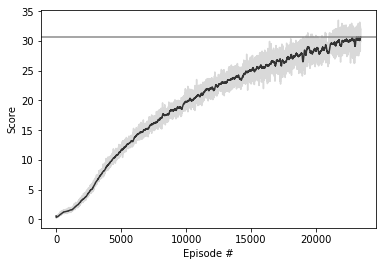

<Figure size 432x288 with 0 Axes>

In [10]:
plot_scores(params['scores'], params['ave_scores'], filename='scores.png', show=True)

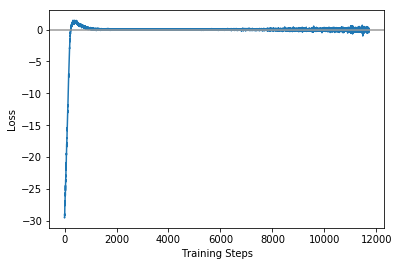

<Figure size 432x288 with 0 Axes>

In [11]:
plot_losses(params['losses'], 'loss.png', show=True)

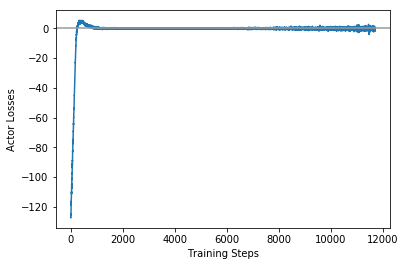

<Figure size 432x288 with 0 Axes>

In [12]:
plot_losses(params['actor_losses'], filename='actor_loss.png', plotName="Actor Losses", show=True)

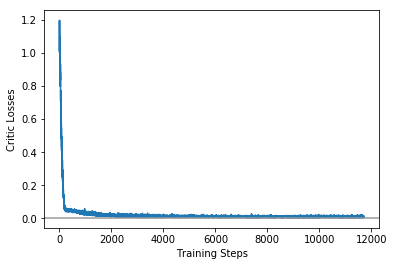

<Figure size 432x288 with 0 Axes>

In [13]:
plot_losses(params['critic_losses'], filename='critic_loss.png', plotName="Critic Losses", show=True)

In [14]:
env.close()